In [1]:
#Peform shap analysis on trained sequence function models
import os 
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from supervised.automl import AutoML
from supervised.model_framework import ModelFramework
from supervised.utils.shap import PlotSHAP

warnings.filterwarnings('ignore')

fc-list: /home/azamh/miniconda3/bin/../lib/././libz.so.1: version `ZLIB_1.2.9' not found (required by /home/azamh/miniconda3/bin/../lib/././libpng16.so.16)


In [2]:
#Arguments
resultsdir = '../automl_stereo'
pruned_msa_df = pd.read_excel(f'../../msa/alignment/pruned_msa_df.xlsx', header = 0, index_col = 0)
pruned_resi_df = pd.read_excel(f'../../msa/alignment/pruned_resi_df.xlsx', header = 0, index_col = 0)
asr_seq_annotations = pd.read_excel('../../si_data/asr_seq_annotations.xlsx', header = 0, index_col = 0)
assert asr_seq_annotations.index.equals(pruned_msa_df.index)

In [3]:
#Load automl object
automl_stereo = AutoML(
    mode = 'Perform', 
    total_time_limit=3600,
    results_path = resultsdir,
    explain_level = 2,
    algorithms = [
                "Xgboost",
                "Random Forest",
                "CatBoost",
            ],
    golden_features=False)
predictions = automl_stereo.predict(pruned_msa_df)

In [4]:
#Load each trained model into dictionary (CatBoost, Random Forest, and XGBoost)
def load_automl_models(automl):

    models_map = {}
    lazy_load = not (
                automl._fit_level is not None and automl._fit_level == "finished"
            )
    for model_subpath in automl._model_subpaths:
        if not model_subpath.endswith("Ensemble") or model_subpath.endswith(
            "Ensemble_Stacked"):
            m = ModelFramework.load(automl.results_path, model_subpath, lazy_load)
            automl._models += [m]
            models_map[m.get_name()] = m
    
    return models_map

models_map = load_automl_models(automl_stereo)

In [5]:
#Get mean shap values across trained models

#DataFrame to hold mean shap values for all models and folds
automl_shap_df = pd.DataFrame()
    
#Iterate over all models
for model, model_framework in models_map.items():
    if model != 'Ensemble':
        print(model)
        modeldir = os.path.join(resultsdir, model)
        #Iterate over folds
        for fold in range(len(model_framework.learners)):
            shap_file = os.path.join(modeldir, f'learner_fold_{fold}_importance.csv')
            if os.path.isfile(shap_file):
                shap_df = pd.read_csv(shap_file)
                
                #Set index as feature
                shap_df = shap_df.set_index('feature')

                #Normalize df
                shap_df=(shap_df-shap_df.min())/(shap_df.max()-shap_df.min())
                automl_shap_df[model] = shap_df['mean_importance']
                automl_shap_df[f'{model}_{fold}'] = shap_df['mean_importance']

#Add mean:
automl_shap_df['mean'] = automl_shap_df.mean(axis = 1)
automl_shap_df = automl_shap_df.sort_values(by = ['mean'], ascending = False)

#Save dataframe
automl_shap_df.to_excel('../shap/stereo_mean_shap.xlsx')

1_Default_Xgboost
2_Default_CatBoost
3_Default_RandomForest
4_Xgboost
8_CatBoost
12_RandomForest
5_Xgboost
9_CatBoost
13_RandomForest
6_Xgboost
10_CatBoost
14_RandomForest
7_Xgboost
11_CatBoost
15_RandomForest
16_CatBoost
17_CatBoost
18_CatBoost
19_RandomForest
20_RandomForest
21_Xgboost
22_Xgboost
23_Xgboost
24_CatBoost
26_RandomForest


In [6]:
automl_shap_df

,1_Default_Xgboost,1_Default_Xgboost_0,1_Default_Xgboost_1,1_Default_Xgboost_2,1_Default_Xgboost_3,1_Default_Xgboost_4,2_Default_CatBoost,2_Default_CatBoost_0,2_Default_CatBoost_1,2_Default_CatBoost_2,...,24_CatBoost_2,24_CatBoost_3,24_CatBoost_4,26_RandomForest,26_RandomForest_0,26_RandomForest_1,26_RandomForest_2,26_RandomForest_3,26_RandomForest_4,mean
feature,,,,,,,,,,,,,,,,,,,,,
239Y,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.618890,1.000000,1.000000,1.000000,0.997459
397Y,0.147380,0.066602,0.047697,0.039415,0.044974,0.147380,0.396677,0.024364,0.051994,0.023148,...,0.037594,0.182835,0.162453,0.399582,0.263636,1.000000,0.123349,0.234668,0.399582,0.148553
97R,0.119245,0.000637,0.034208,0.062713,0.127498,0.119245,0.061880,0.050330,0.010163,0.014504,...,0.031198,0.029508,0.017605,0.225486,0.092570,0.575751,0.149984,0.098574,0.225486,0.144216
55A,0.061074,0.206181,0.179162,0.045448,0.026740,0.061074,0.020097,0.207801,0.154911,0.191104,...,0.311507,0.175087,0.162599,0.027281,0.070267,0.052564,0.026636,0.033419,0.027281,0.141982
425I,0.071705,0.120932,0.154050,0.156071,0.142212,0.071705,0.098896,0.093890,0.042482,0.046755,...,0.031198,0.236715,0.167315,0.096076,0.031469,0.058372,0.088382,0.122472,0.096076,0.091583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249I,0.028192,0.032780,0.058837,0.028368,0.026355,0.028192,0.021020,0.034590,0.000000,0.014504,...,0.031198,0.045523,0.020293,0.022227,0.021204,0.019309,0.039655,0.033419,0.022227,0.032407
396L,0.029085,0.031139,0.044699,0.030798,0.042673,0.029085,0.031716,0.024364,0.019393,0.022118,...,0.031198,0.051717,0.017605,0.010823,0.025712,0.040204,0.033943,0.033419,0.010823,0.032364
236L,0.034809,0.020687,0.061116,0.040344,0.035592,0.034809,0.005997,0.020163,0.004930,0.014504,...,0.031198,0.074207,0.017605,0.016272,0.020356,0.019309,0.039655,0.025386,0.016272,0.031949


<AxesSubplot: xlabel='feature', ylabel='mean'>

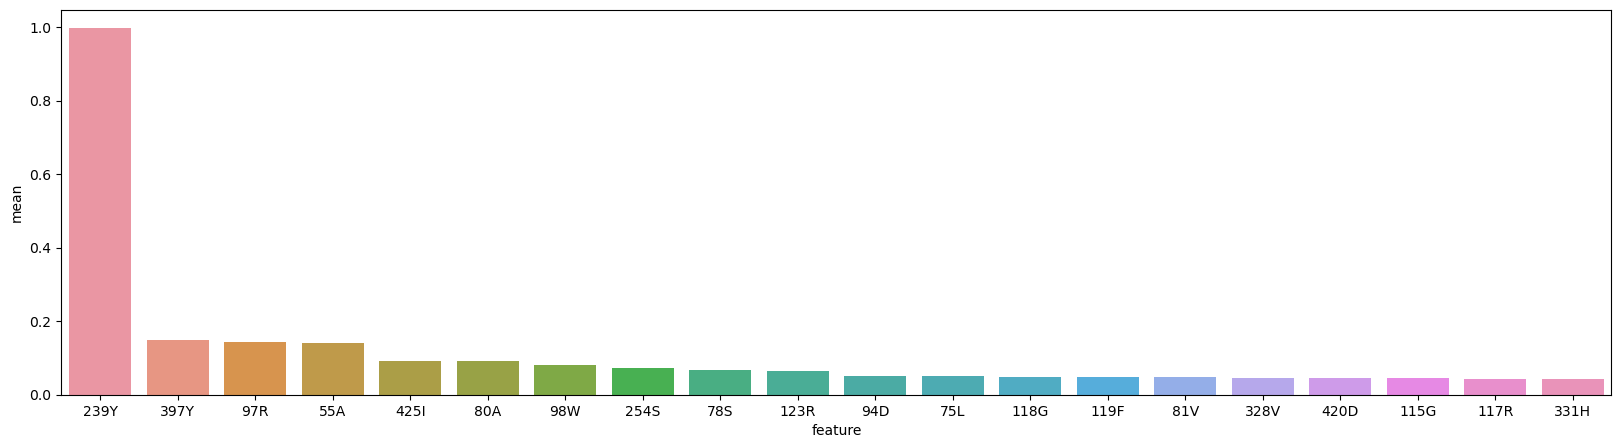

In [7]:
#Plot features by mean SHAP value
fig = plt.figure(figsize=(20,5))
sns.barplot(automl_shap_df[0:20], x = automl_shap_df.index[0:20], y = 'mean')

In [8]:
#Get shap explanations for every single sequence to understand how residue type corresponds to stereochemistry

#Return a dictionary mapping model folds to shap explainers and shap values
def get_model_learner_explainers(model_framework, X_data_automl, Y_data_automl, ml_task):

    #Dictionary holding fold_shap_values
    fold_dict = dict()

    for fold, (learner, preprocessing) in enumerate(zip(model_framework.learners, model_framework.preprocessings)):
        fold_df = pd.DataFrame(index = X_data_automl.index, columns = X_data_automl.columns)

        #Transform X and Y data
        try:
            X_data_transform, Y_data_transform, sample_weight = preprocessing.fit_and_transform(X_data_automl, Y_data_automl)
        except KeyError:
            print(KeyError)
            break 
        
        #Get shap explainer and shap values
        try:
            shap_explainer = PlotSHAP.get_explainer(learner, X_data_transform)
            shap_values = np.array(shap_explainer.shap_values(X_data_transform))
            expected_values = shap_explainer.expected_value
        except Exception as e:
            print(e)
            break

        fold_dict[fold] = [shap_explainer, shap_values, expected_values, X_data_transform]
                
    return fold_dict

#Normalize SHAP values between -1 and 1
def normalize_array(x, a=-1, b=1):
    return (b-a) * ((x - np.min(x)) /  (np.max(x) - np.min(x))) + a

In [12]:
#Use SHAP explainer to get shap values for every input

#Parse X and Y data into autoML object
X_data_automl, Y_data_automl, sample_weight = automl_stereo._build_dataframe(pruned_msa_df.copy(deep = True), 
                                                                      asr_seq_annotations['average_pred_stereo'].copy(deep = True))
#Parse all models and learners
all_fold_shap_dfs = []
for model_name, model_framework in list(models_map.items()):
    print(model_name)
    
    #Get SHAP explainers for each fold
    fold_dict = get_model_learner_explainers(model_framework, 
                                             X_data_automl.copy(deep=True), 
                                             Y_data_automl.copy(deep=True), 
                                             automl_stereo.ml_task)
    
    #Normalize shap values for each fold
    for fold in fold_dict:
        fold_shap_explainer, fold_shap_values, fold_expected_values, fold_X = fold_dict[fold]
        if fold_shap_values.ndim == 3: #Get R class
            fold_shap_values = fold_shap_values[-1]
        #Normalize shap values
        fold_shap_values = normalize_array(fold_shap_values)
        fold_proteins = [f'{protein}_{model_name}_{fold}' for protein in pruned_msa_df.index]
        fold_df = pd.DataFrame(data = fold_shap_values, index = pruned_msa_df.index, columns = [f'{x}_shap' for x in fold_X.columns])
        fold_df = pd.concat([fold_df, pruned_msa_df], axis = 1)
        fold_df.index = fold_proteins
        all_fold_shap_dfs.append(fold_df)
        
all_fold_shap_df = pd.concat(all_fold_shap_dfs)

1_Default_Xgboost
2_Default_CatBoost
3_Default_RandomForest
4_Xgboost
8_CatBoost
12_RandomForest
5_Xgboost
9_CatBoost
13_RandomForest
6_Xgboost
10_CatBoost
14_RandomForest
7_Xgboost
11_CatBoost
15_RandomForest
16_CatBoost
17_CatBoost
18_CatBoost
19_RandomForest
20_RandomForest
21_Xgboost
22_Xgboost
23_Xgboost
24_CatBoost
26_RandomForest


In [13]:
#Dataframe contains every single sequence (~800) * all trained models (~25) * all folds (5) ~ 100,000 data points
all_fold_shap_df

,22I_shap,50I_shap,51G_shap,52A_shap,53G_shap,54M_shap,55A_shap,56F_shap,57T_shap,58A_shap,...,419K,420D,421R,422S,423H,424K,425I,426W,427H,428F
0_1_Default_Xgboost_0,0.277570,0.297031,0.272510,0.192403,0.267626,0.267626,0.378915,0.297373,0.277866,0.287726,...,K,E,L,L,L,L,L,W,E,Y
1_1_Default_Xgboost_0,0.277570,0.296679,0.272510,0.192403,0.267626,0.267626,0.374998,0.256224,0.272202,0.289595,...,K,E,L,L,L,L,L,W,E,Y
2_1_Default_Xgboost_0,0.274129,0.265547,0.269027,0.195174,0.267626,0.267626,0.345268,0.266871,0.268137,0.285477,...,Q,E,R,S,H,K,L,W,N,Y
3_1_Default_Xgboost_0,0.274129,0.265547,0.269027,0.195174,0.267626,0.267626,0.345268,0.266871,0.268137,0.285477,...,Q,E,R,S,H,K,L,W,N,Y
4_1_Default_Xgboost_0,0.284848,0.265847,0.269027,0.195174,0.267626,0.267626,0.372034,0.266804,0.288041,0.283558,...,L,E,R,S,H,Q,L,W,D,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825_26_RandomForest_4,-0.322075,-0.322075,-0.321205,-0.322075,-0.322075,-0.322775,-0.337409,-0.322075,-0.322075,-0.324136,...,N,R,R,N,A,I,I,T,D,A
826_26_RandomForest_4,-0.322075,-0.322075,-0.377440,-0.322075,-0.322075,-0.321650,-0.371883,-0.322075,-0.322075,-0.322570,...,W,Q,R,Y,T,Q,I,W,E,F
827_26_RandomForest_4,-0.322075,-0.322075,-0.321205,-0.322075,-0.322075,-0.321629,-0.319271,-0.322075,-0.322075,-0.324136,...,K,E,R,S,H,R,I,W,D,F
828_26_RandomForest_4,-0.322075,-0.322075,-0.321205,-0.322075,-0.322075,-0.321208,-0.315316,-0.322075,-0.322075,-0.322894,...,K,D,R,S,Y,K,I,W,H,F


<AxesSubplot: xlabel='239Y', ylabel='239Y_shap'>

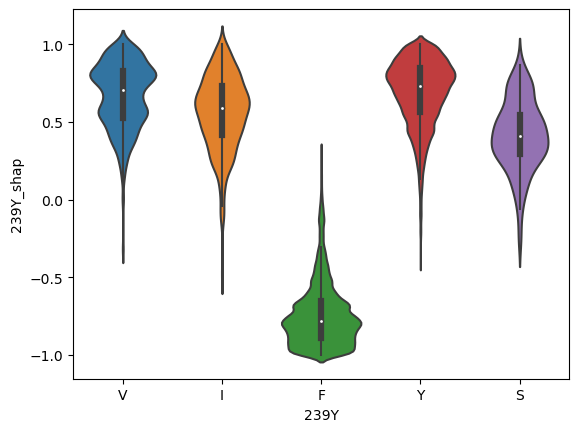

In [11]:
#Create dependence plot for resi 239
#Positive shap value indicates R and negative indicates S
#Dependence plot is all shap values across all folds of all trained models (100,000 points)
sns.violinplot(data = all_fold_shap_df, y = f'239Y_shap', x = '239Y')